# S&P500 Custom Portfolio Tool

Most of the popular ETFs on the market today track the entire S&P500 index as quick and easy way to give passive investors exposure to US equities while being reasonably diversified. However, if we were to fine tune which sectors of the index we want to be invested in, how might that portfolio perform? 

Using a sampling of the largest 10 companies from each sector, I will:
    1. Display sector performance of the last 5 years
    2. Rank correlations between sectors
    3. Depict average risk vs standard deviation
    4. Backtest a custom portfolio of equally weighted sectors
    5. Simulate future performance of a custom portfolio with a range of probabilistic outcomes

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import pandas_datareader.data as pdr

from datetime import datetime

from __future__ import division

from ipywidgets import interact, fixed, IntSlider

# Find the largest 10 companies from each sector

In [2]:
# Pull in S&P500 tickers from wikipedia
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
Ticker=table[0]['Symbol']
## Replace periods to dashes for yahoo data
Ticker = Ticker.str.replace('.','-')

# Pull in Sectors
Sector=table[0]['GICS Sector']

# And combine to see what we have so far
SP500 = DataFrame({"Ticker":Ticker, "Sector":Sector})
SP500

Ticker                  Sector
0      MMM             Industrials
1      ABT             Health Care
2     ABBV             Health Care
3     ABMD             Health Care
4      ACN  Information Technology
..     ...                     ...
500    YUM  Consumer Discretionary
501   ZBRA  Information Technology
502    ZBH             Health Care
503   ZION              Financials
504    ZTS             Health Care

[505 rows x 2 columns]

In [3]:
# Grab market cap data from yahoo
marketCap=pdr.get_quote_yahoo(Ticker)['marketCap']

In [4]:
# Join it with our data frame
SP500 = pd.merge(SP500,marketCap,left_on=Ticker,right_index=True)

# Clean it up
SP500=SP500.rename(columns={'marketCap':'MarketCap'})
SP500=SP500.drop('key_0',axis=1)

#Sort by market cap and return
SP500=SP500.sort_values(by=['MarketCap'], ascending=False)
SP500

Ticker                  Sector      MarketCap
45    AAPL  Information Technology  2243727458304
316   MSFT  Information Technology  1684101398528
25    AMZN  Consumer Discretionary  1591900372992
23    GOOG  Communication Services  1174760194048
22   GOOGL  Communication Services  1174404333568
..     ...                     ...            ...
497    XRX  Information Technology     4479533056
462    UNM              Financials     4464270848
433    FTI                  Energy     4268351744
414    SLG             Real Estate     4117599232
229    HFC                  Energy     4107130880

[505 rows x 3 columns]

In [5]:
# Let's see the SP500 sectors
SP500['Sector'].unique()

array(['Information Technology', 'Consumer Discretionary',
       'Communication Services', 'Financials', 'Consumer Staples',
       'Health Care', 'Energy', 'Industrials', 'Utilities', 'Materials',
       'Real Estate'], dtype=object)

In [6]:
# Separate SP500 by sector, take first 10 values from each sector and store in dictionary
sector = {}

for x in SP500['Sector'].unique():
    sector[x] = SP500[SP500['Sector'] == x][:10]

In [7]:
# Test to see if everything worked
sector['Consumer Staples']

Ticker            Sector     MarketCap
479    WMT  Consumer Staples  406003122176
376     PG  Consumer Staples  341491908608
114     KO  Consumer Staples  229654659072
363    PEP  Consumer Staples  200467103744
128   COST  Consumer Staples  161492533248
367     PM  Consumer Staples  128494469120
173     EL  Consumer Staples   94361092096
320   MDLZ  Consumer Staples   82734751744
24      MO  Consumer Staples   77533282304
116     CL  Consumer Staples   72893652992

We now have the 10 largest companies of each sector

# 1. Display sector performance of the last 5 years

In [8]:
# Pull in the stock adjusted closing price over the last 5 years 

end = datetime.now()
start = datetime(end.year-5,end.month,end.day)

InformationTechnology = pdr.get_data_yahoo(sector['Information Technology']['Ticker'],start=start,end=end)['Adj Close']
ConsumerDiscretionary = pdr.get_data_yahoo(sector['Consumer Discretionary']['Ticker'],start=start,end=end)['Adj Close']
CommunicationServices = pdr.get_data_yahoo(sector['Communication Services']['Ticker'],start=start,end=end)['Adj Close']
Financials = pdr.get_data_yahoo(sector['Financials']['Ticker'],start=start,end=end)['Adj Close']
ConsumerStaples = pdr.get_data_yahoo(sector['Consumer Staples']['Ticker'],start=start,end=end)['Adj Close']
HealthCare = pdr.get_data_yahoo(sector['Health Care']['Ticker'],start=start,end=end)['Adj Close']
Energy = pdr.get_data_yahoo(sector['Energy']['Ticker'],start=start,end=end)['Adj Close']
Industrials = pdr.get_data_yahoo(sector['Industrials']['Ticker'],start=start,end=end)['Adj Close']
Utilities = pdr.get_data_yahoo(sector['Utilities']['Ticker'],start=start,end=end)['Adj Close']
Materials = pdr.get_data_yahoo(sector['Materials']['Ticker'],start=start,end=end)['Adj Close']
RealEstate = pdr.get_data_yahoo(sector['Real Estate']['Ticker'],start=start,end=end)['Adj Close']

In [9]:
# And make a new dataframe of the average adjusted closing prices of each sector 
SectorAvg = DataFrame({'InformationTechnology' : InformationTechnology.mean(axis='columns'),
                        'ConsumerDiscretionary' : ConsumerDiscretionary.mean(axis='columns'),
                      'CommunicationServices' : CommunicationServices.mean(axis='columns'),
                      'Financials' : Financials.mean(axis='columns'),
                      'ConsumerStaples': ConsumerStaples.mean(axis='columns'),
                      'HealthCare' : HealthCare.mean(axis='columns'),
                      'Energy' : Energy.mean(axis='columns'),
                      'Industrials' : Industrials.mean(axis='columns'),
                      'Utilities' : Utilities.mean(axis='columns'),
                      'Materials' : Materials.mean(axis='columns'),
                      'RealEstate' : RealEstate.mean(axis='columns')})

In [10]:
# Let's take a look at some of our new data frame
SectorAvg.tail()

InformationTechnology  ConsumerDiscretionary  \
Date                                                       
2020-12-18             250.711999             712.370981   
2020-12-21             250.090998             705.718986   
2020-12-22             251.518002             703.043013   
2020-12-23             248.253002             706.243008   
2020-12-24             249.547998             705.367009   

            CommunicationServices  Financials  ConsumerStaples  HealthCare  \
Date                                                                         
2020-12-18             536.564998  163.384999       138.598435  180.365547   
2020-12-21             537.010004  165.936004       136.922860  178.965544   
2020-12-22             531.934996  163.742002       136.246642  178.426810   
2020-12-23             533.416995  166.809002       136.456002  177.561000   
2020-12-24             535.542996  167.225999       137.237000  178.255001   

               Energy  Industrials  Utilities   Materials  RealEstate  
Date                                                                   
2020-12-18  44.234000   187.366001  76.352733  192.250998  200.364049  
2020-12-21  43.512000   185.841002  75.350000  191.123997  199.007789  
2020-12-22  43.011000   185.120003  75.168000  191.301002  200.893283  
2020-12-23  44.058001   185.702002  74.891999  190.219002  198.431004  
2020-12-24  43.785000   185.843999  75.376001  192.021003  199.886998

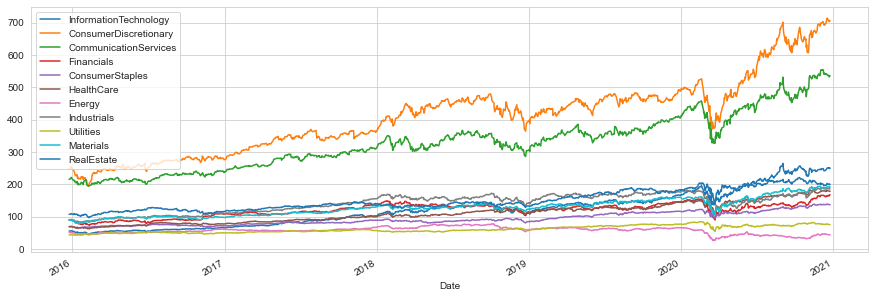

In [11]:
# Adjusted Close price over time

SectorAvg.plot(legend = True, figsize = (15,5))

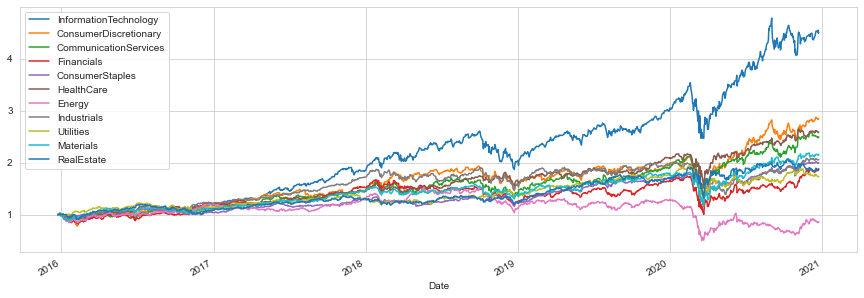

In [12]:
# Kind of difficult to make assumptions just off the adjusted close. Let's take a look at the percent change over time
SectorPctReturn = (SectorAvg/SectorAvg.iloc[0])
SectorPctReturn.plot(figsize = (15,5))

# 2. Rank correlations between sectors

In [13]:
# Create data frame of the daily percent change
SectorDailyReturn = SectorAvg.pct_change()
SectorDailyReturn.tail()

InformationTechnology  ConsumerDiscretionary  \
Date                                                       
2020-12-18               0.002487              -0.002230   
2020-12-21              -0.002477              -0.009338   
2020-12-22               0.005706              -0.003792   
2020-12-23              -0.012981               0.004552   
2020-12-24               0.005216              -0.001240   

            CommunicationServices  Financials  ConsumerStaples  HealthCare  \
Date                                                                         
2020-12-18              -0.005315   -0.008929        -0.001183    0.000112   
2020-12-21               0.000829    0.015613        -0.012089   -0.007762   
2020-12-22              -0.009450   -0.013222        -0.004939   -0.003010   
2020-12-23               0.002786    0.018731         0.001537   -0.004852   
2020-12-24               0.003986    0.002500         0.005723    0.003909   

              Energy  Industrials  Utilities  Materials  RealEstate  
Date                                                                 
2020-12-18 -0.015118     0.005004  -0.009428   0.003314   -0.011587  
2020-12-21 -0.016322    -0.008139  -0.013133  -0.005862   -0.006769  
2020-12-22 -0.011514    -0.003880  -0.002415   0.000926    0.009474  
2020-12-23  0.024343     0.003144  -0.003672  -0.005656   -0.012257  
2020-12-24 -0.006196     0.000765   0.006463   0.009473    0.007338

In [14]:
# And create a data frame of the correlations between sectors
SectorCorr = SectorDailyReturn.corr()
SectorCorr

InformationTechnology  ConsumerDiscretionary  \
InformationTechnology               1.000000               0.803389   
ConsumerDiscretionary               0.803389               1.000000   
CommunicationServices               0.834890               0.788716   
Financials                          0.701396               0.660698   
ConsumerStaples                     0.662157               0.608984   
HealthCare                          0.731294               0.628632   
Energy                              0.538578               0.535014   
Industrials                         0.682462               0.644454   
Utilities                           0.437281               0.382926   
Materials                           0.699234               0.615727   
RealEstate                          0.611616               0.520245   

                       CommunicationServices  Financials  ConsumerStaples  \
InformationTechnology               0.834890    0.701396         0.662157   
ConsumerDiscretionary               0.788716    0.660698         0.608984   
CommunicationServices               1.000000    0.650733         0.622707   
Financials                          0.650733    1.000000         0.648107   
ConsumerStaples                     0.622707    0.648107         1.000000   
HealthCare                          0.673507    0.706234         0.717335   
Energy                              0.507681    0.739131         0.482697   
Industrials                         0.630287    0.838700         0.682035   
Utilities                           0.395081    0.486829         0.693909   
Materials                           0.625206    0.788443         0.680511   
RealEstate                          0.538456    0.560725         0.699581   

                       HealthCare    Energy  Industrials  Utilities  \
InformationTechnology    0.731294  0.538578     0.682462   0.437281   
ConsumerDiscretionary    0.628632  0.535014     0.644454   0.382926   
CommunicationServices    0.673507  0.507681     0.630287   0.395081   
Financials               0.706234  0.739131     0.838700   0.486829   
ConsumerStaples          0.717335  0.482697     0.682035   0.693909   
HealthCare               1.000000  0.523093     0.702588   0.574794   
Energy                   0.523093  1.000000     0.736264   0.423094   
Industrials              0.702588  0.736264     1.000000   0.557384   
Utilities                0.574794  0.423094     0.557384   1.000000   
Materials                0.719331  0.660822     0.795804   0.561099   
RealEstate               0.662092  0.428455     0.572650   0.734635   

                       Materials  RealEstate  
InformationTechnology   0.699234    0.611616  
ConsumerDiscretionary   0.615727    0.520245  
CommunicationServices   0.625206    0.538456  
Financials              0.788443    0.560725  
ConsumerStaples         0.680511    0.699581  
HealthCare              0.719331    0.662092  
Energy                  0.660822    0.428455  
Industrials             0.795804    0.572650  
Utilities               0.561099    0.734635  
Materials               1.000000    0.625278  
RealEstate              0.625278    1.000000

### Let's graph this and see if we can make any insight

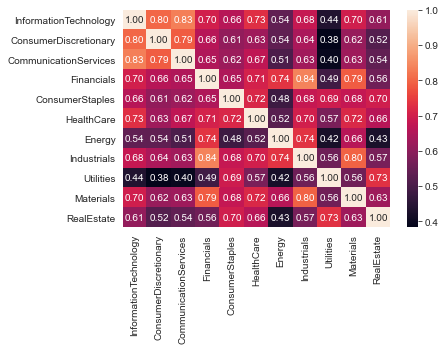

In [15]:
sns.heatmap(SectorCorr,annot=True,fmt='.2f')

#### We have the values, but we have an issue of self correlations and redundant pairs

In [16]:
# We can set the lower triangle of the correlation matrix to ones, set it as a boolean, 
# and use the mask function to return all the values that are not ones.
SectorCorr = SectorCorr.mask(np.triu(np.ones(SectorCorr.shape)).astype(np.bool))
print(SectorCorr)

                       InformationTechnology  ConsumerDiscretionary  \
InformationTechnology                    NaN                    NaN   
ConsumerDiscretionary               0.803389                    NaN   
CommunicationServices               0.834890               0.788716   
Financials                          0.701396               0.660698   
ConsumerStaples                     0.662157               0.608984   
HealthCare                          0.731294               0.628632   
Energy                              0.538578               0.535014   
Industrials                         0.682462               0.644454   
Utilities                           0.437281               0.382926   
Materials                           0.699234               0.615727   
RealEstate                          0.611616               0.520245   

                       CommunicationServices  Financials  ConsumerStaples  \
InformationTechnology                    NaN         NaN              

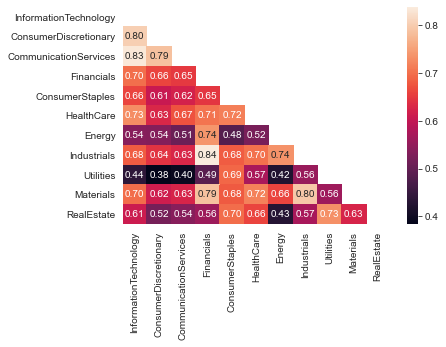

In [17]:
# Graph clean correlation heat map
sns.heatmap(SectorCorr,annot=True,fmt='.2f')

In [18]:
# Reshape and sort our data frame to rank the pairs of sectors
SectorCorrRank=SectorCorr.stack().reset_index().sort_values(by=0,ascending=False)
SectorCorrRank.rename(columns={'level_0':'Sector X','level_1':'Sector Y',0:'R-value'},inplace=True)
SectorCorrRank

Sector X               Sector Y   R-value
24            Industrials             Financials  0.838700
1   CommunicationServices  InformationTechnology  0.834890
0   ConsumerDiscretionary  InformationTechnology  0.803389
43              Materials            Industrials  0.795804
2   CommunicationServices  ConsumerDiscretionary  0.788716
39              Materials             Financials  0.788443
18                 Energy             Financials  0.739131
27            Industrials                 Energy  0.736264
53             RealEstate              Utilities  0.734635
10             HealthCare  InformationTechnology  0.731294
41              Materials             HealthCare  0.719331
14             HealthCare        ConsumerStaples  0.717335
13             HealthCare             Financials  0.706234
26            Industrials             HealthCare  0.702588
3              Financials  InformationTechnology  0.701396
49             RealEstate        ConsumerStaples  0.699581
36              Materials  InformationTechnology  0.699234
32              Utilities        ConsumerStaples  0.693909
21            Industrials  InformationTechnology  0.682462
25            Industrials        ConsumerStaples  0.682035
40              Materials        ConsumerStaples  0.680511
12             HealthCare  CommunicationServices  0.673507
6         ConsumerStaples  InformationTechnology  0.662157
50             RealEstate             HealthCare  0.662092
42              Materials                 Energy  0.660822
4              Financials  ConsumerDiscretionary  0.660698
5              Financials  CommunicationServices  0.650733
9         ConsumerStaples             Financials  0.648107
22            Industrials  ConsumerDiscretionary  0.644454
23            Industrials  CommunicationServices  0.630287
11             HealthCare  ConsumerDiscretionary  0.628632
54             RealEstate              Materials  0.625278
38              Materials  CommunicationServices  0.625206
8         ConsumerStaples  CommunicationServices  0.622707
37              Materials  ConsumerDiscretionary  0.615727
45             RealEstate  InformationTechnology  0.611616
7         ConsumerStaples  ConsumerDiscretionary  0.608984
33              Utilities             HealthCare  0.574794
52             RealEstate            Industrials  0.572650
44              Materials              Utilities  0.561099
48             RealEstate             Financials  0.560725
35              Utilities            Industrials  0.557384
15                 Energy  InformationTechnology  0.538578
47             RealEstate  CommunicationServices  0.538456
16                 Energy  ConsumerDiscretionary  0.535014
20                 Energy             HealthCare  0.523093
46             RealEstate  ConsumerDiscretionary  0.520245
17                 Energy  CommunicationServices  0.507681
31              Utilities             Financials  0.486829
19                 Energy        ConsumerStaples  0.482697
28              Utilities  InformationTechnology  0.437281
51             RealEstate                 Energy  0.428455
34              Utilities                 Energy  0.423094
30              Utilities  CommunicationServices  0.395081
29              Utilities  ConsumerDiscretionary  0.382926

# 3. Depict average return vs standard deviation

In [19]:
SectorVolatility = DataFrame({'Average Return':SectorDailyReturn.mean(), 'Standard Deviation':SectorDailyReturn.std()})
SectorVolatility.reset_index(inplace=True)
SectorVolatility.rename(columns={'index':'Sector'}, inplace=True)
SectorVolatility

Sector  Average Return  Standard Deviation
0   InformationTechnology        0.001346            0.017196
1   ConsumerDiscretionary        0.000942            0.014993
2   CommunicationServices        0.000835            0.014707
3              Financials        0.000639            0.016556
4         ConsumerStaples        0.000605            0.010534
5              HealthCare        0.000828            0.012100
6                  Energy        0.000097            0.020874
7             Industrials        0.000677            0.014403
8               Utilities        0.000527            0.013360
9               Materials        0.000712            0.014086
10             RealEstate        0.000589            0.013572

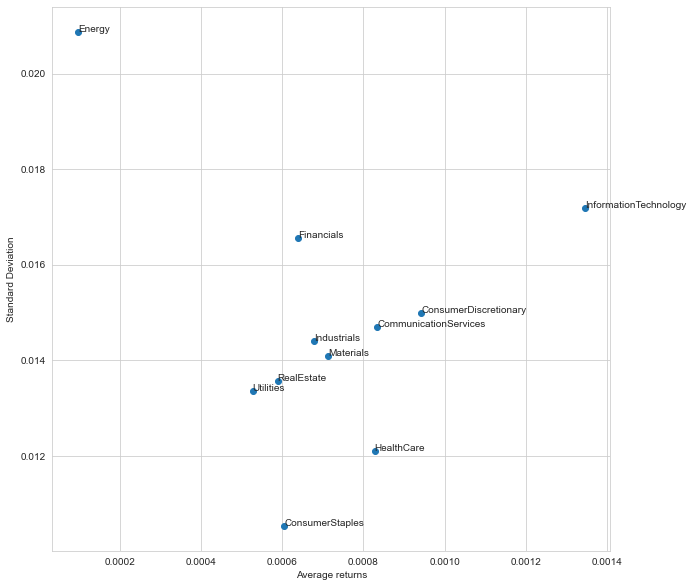

In [20]:
plt.figure(figsize=(10,10))
plt.xlabel('Average returns')
plt.ylabel('Standard Deviation')
plt.scatter(SectorVolatility['Average Return'],SectorVolatility['Standard Deviation'])
for i, txt in enumerate(SectorVolatility['Sector']):
    plt.annotate(txt,(SectorVolatility['Average Return'][i], SectorVolatility['Standard Deviation'][i]),fontsize=10)

# 4. Backtest a custom portfolio of equally weighted sectors

##### We can create a custom portfolio by choosing our desired sectors
Once we've made our selections, we can see how our portfolio would have performed in the past

In [21]:
def portfolio_active(secs, **active):
    filtered = [s for s in secs if active.get(s,True)]
    prices = [SectorAvg[s] for s in filtered]
    unit_pos = [p / p.iloc[0] for p in prices]
    basket = sum(u for u in unit_pos) / len(unit_pos)
    for p in unit_pos:
        p.plot(alpha=0.4,legend=True)
    basket.plot(figsize=(20,10),color='r',title="Custom Portfolio Performance")

# Red line shows portfolio performance

In [22]:
sec_prf = ['InformationTechnology','ConsumerDiscretionary','CommunicationServices','Financials','ConsumerStaples','HealthCare','Energy','Industrials','Utilities','Materials','RealEstate']
active = dict(zip(sec_prf, [True] * len(sec_prf)))
_ = interact(portfolio_active, secs =fixed(sec_prf),**active)

interactive(children=(Checkbox(value=True, description='InformationTechnology'), Checkbox(value=True, descript…

# 5. Simulate future performance of a custom portfolio with a range of probabilistic outcomes

#### Monte-Carlo Simulation - 1000 simulations

In [23]:
def future_performance(secs, time_horizon=365,**active):
    filtered = [s for s in secs if active.get(s,True)]
    sec_prf_prices = pd.concat((SectorAvg[s] for s in filtered),axis=1, keys=sec_prf)
    sec_prf_returns = (sec_prf_prices.pct_change() + 1)[1:]
    number_of_simulations=1000
    simulated = pd.DataFrame([(sec_prf_returns.iloc[random.choices(
    range(len(sec_prf_returns)), k=time_horizon)]).mean(axis=1).cumprod().values 
                         for x in range(number_of_simulations)]).T
    simulated.plot(legend=False, linewidth=1, alpha=0.1, color='blue', figsize=(20,5))
    simulated.quantile([0.05, 0.50, 0.95], axis=1).T.plot(figsize=(20,5))
    plt.figtext(0.85, 0.7, "q(0.95): %.2f" % np.quantile(simulated,0.95))
    plt.figtext(0.85, 0.6, "q(0.50): %.2f" % np.quantile(simulated,0.50))
    plt.figtext(0.85, 0.5, "q(0.05): %.2f" % np.quantile(simulated,0.05))

In [24]:
sec_prf = ['InformationTechnology','ConsumerDiscretionary','CommunicationServices','Financials','ConsumerStaples','HealthCare','Energy','Industrials','Utilities','Materials','RealEstate']
active = dict(zip(sec_prf, [True] * len(sec_prf)))
_ = interact(future_performance, secs =fixed(sec_prf), time_horizon=IntSlider(min=60, value=365,max=365),**active)

interactive(children=(IntSlider(value=365, description='time_horizon', max=365, min=60), Checkbox(value=True, …